### Проверка статистических гипотез методом BOOTSTRAP

**Описание эксперимента**

Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом

**Описание колонок**

*value* – значения метрики

*experimentVariant* – Вариант теста (Control – контроль, Treatment – тест)

**Задача**

**1. Сравните результат между тестом и контролем по двум кейсам:**

Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.

**2. Напишите выводы, которые можно сделать на основе анализа примененных критериев**

Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
import seaborn as sns
sns.set (
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
)

Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [3]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

Считаем файл с нужным нам разделителем и сохраним в переменную

In [4]:
df = pd.read_csv('hw_bootstrap.csv', sep=';')
df

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control
...,...,...,...
995,996,1000,Treatment
996,997,1200,Treatment
997,998,1500,Treatment
998,999,2000,Treatment


Создадим 2 различных ДФ, для каждой группы

In [5]:
control = df.query('experimentVariant == "Control"')
test = df.query('experimentVariant == "Treatment"')

Проверим датафреймы на предмет наличия пустых значений

In [6]:
test.isna().sum()

Unnamed: 0           0
value                0
experimentVariant    0
dtype: int64

In [7]:
control.isna().sum()

Unnamed: 0           0
value                0
experimentVariant    0
dtype: int64

Пустыйх значений нет. 

Запускаем U критерий Манна-Уитни  

In [8]:
mannwhitneyu(control.value, test.value)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Ага, что пошло не так...

Посмотрим типы данных, может там закралась ошибка

In [9]:
test.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

Предобработаем данные для приведения к нужному типу

In [10]:
control['value'] = control.value.str.replace(',', '.')
test['value'] = test.value.str.replace(',', '.')
control['value'] = control['value'].astype('float')
test['value'] = test['value'].astype('float')

/var/folders/51/8wdxn1pj7zn8mhf5t08vk7080000gn/T/ipykernel_1669/3540300418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control['value'] = control.value.str.replace(',', '.')
/var/folders/51/8wdxn1pj7zn8mhf5t08vk7080000gn/T/ipykernel_1669/3540300418.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['value'] = test.value.str.replace(',', '.')
/var/folders/51/8wdxn1pj7zn8mhf5t08vk7080000gn/T/ipykernel_1669/3540300418.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [11]:
# Получилось
test.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

**Запускаем тест Манна-Уитни**

In [12]:
mannwhitneyu(control.value, test.value)


MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

Исходя из результата теста, мы не можем отвергнуть нулевую гипотезу.

В данном эксперементе мы не нашли стастистически значимых отличий

**Теперь запустим бутстреп, с медианой**

  0%|          | 0/500 [00:00<?, ?it/s]

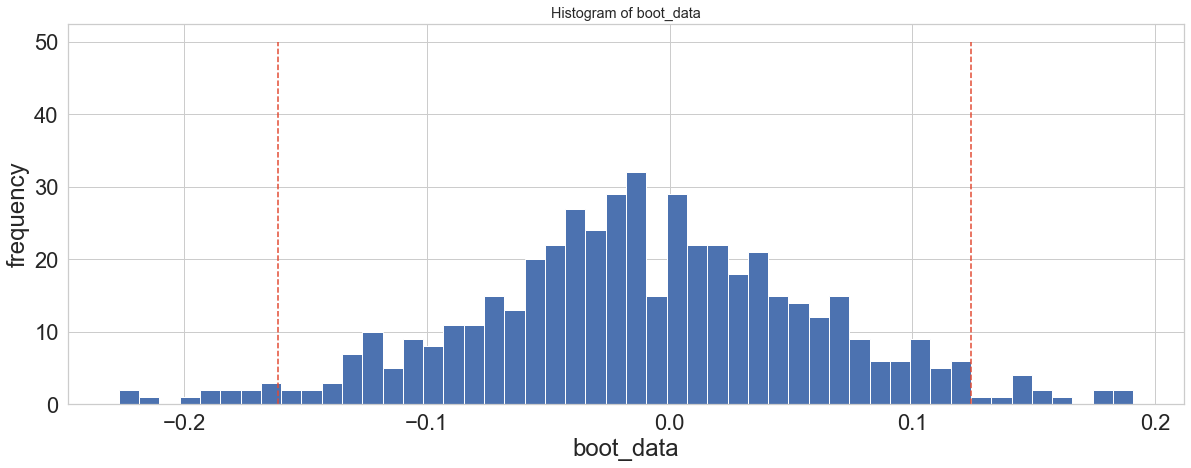

In [13]:
booted_data = get_bootstrap(control.value, test.value, statistic = np.median, boot_it = 500)

Посмотрим уровень значимости...

In [14]:
booted_data["p_value"]

0.8771743894361035

In [15]:
booted_data["ci"]

,0
0.025,-0.161179
0.975,0.124210


И получаем результат, примерно соответствующий таковому при применении критерия Манна-Уитни

Настало время **бутстрепа с np.mean**

  0%|          | 0/500 [00:00<?, ?it/s]

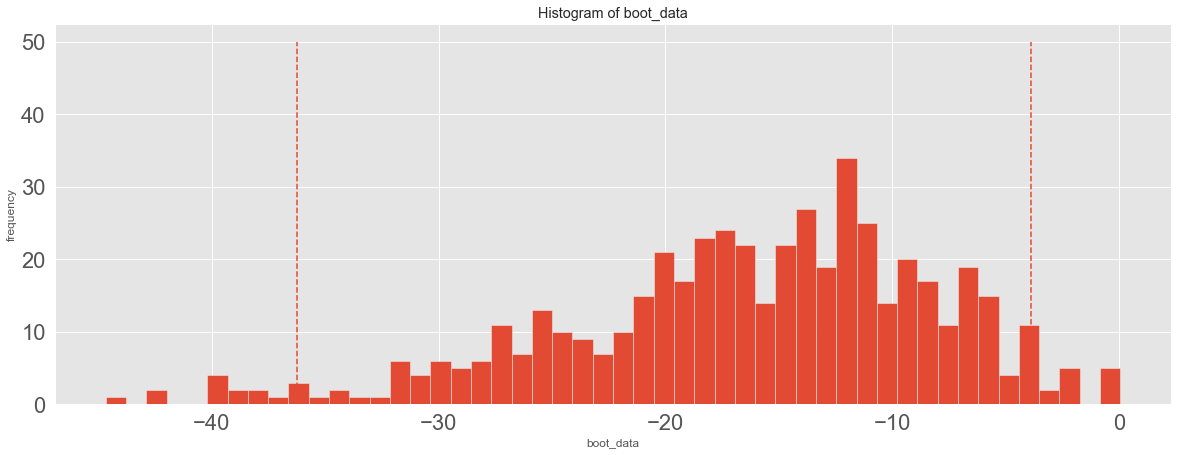

In [16]:
booted_data = get_bootstrap(control.value, test.value, statistic = np.mean, boot_it = 500)

Посмотрим уровень значимости...

In [17]:
booted_data["p_value"]

0.04625102658744029

И противоположный результат, при котором мы можем отвергуть нулевую гипотезу. 

Значит, скорее всего, мы имеем дело с большими выбросами в какой-то группе/группах

Построим гистограмму группы control

<AxesSubplot:>

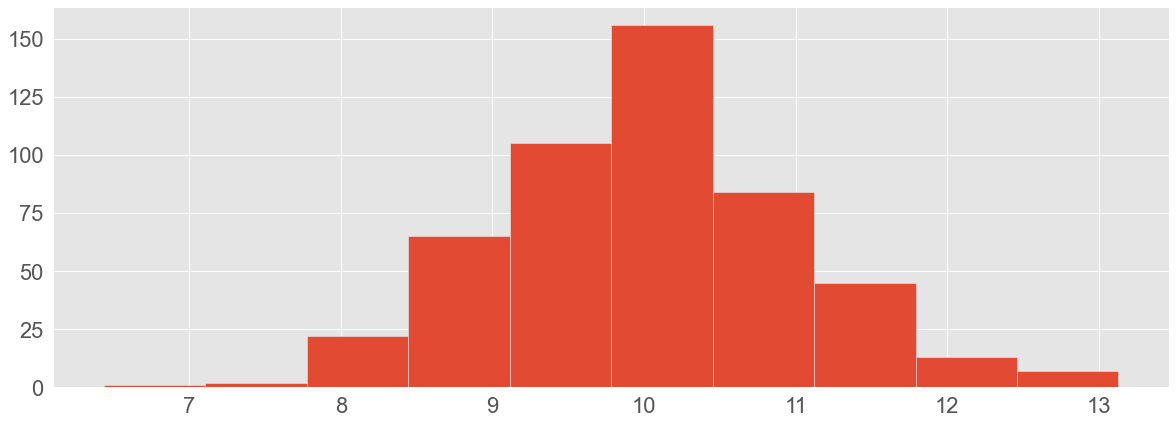

In [18]:
control.value.hist()

Построим гистограмму группы test

<AxesSubplot:>

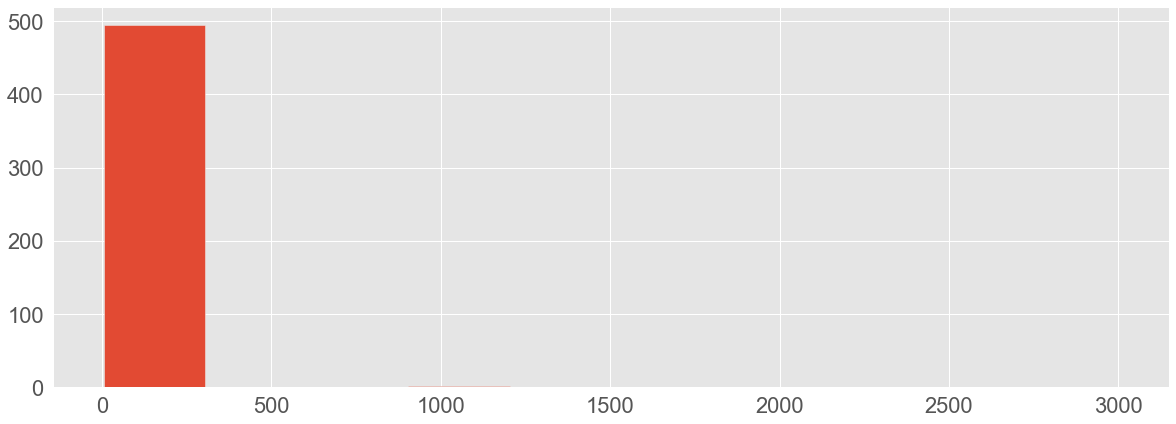

In [19]:
test.value.hist()

Построим ящик-с-усами в группе тест

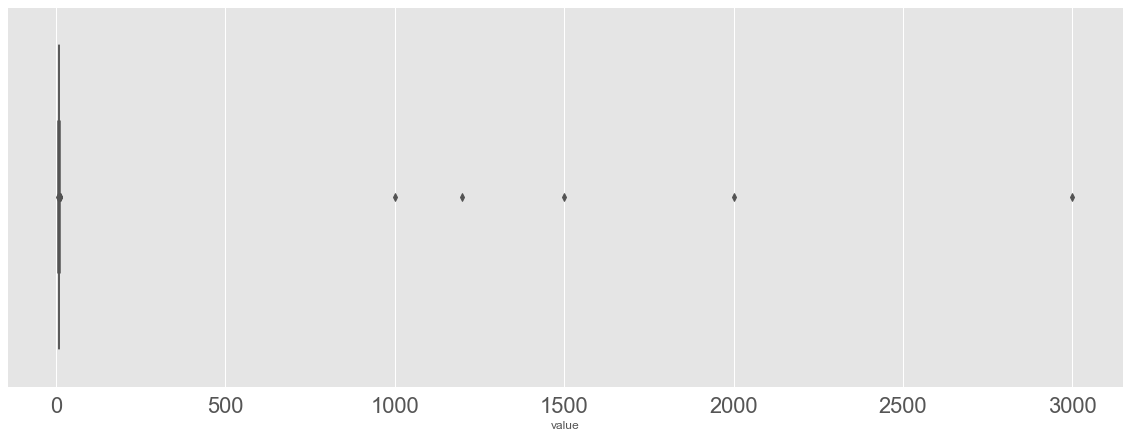

In [20]:
ax = sns.boxplot(x="value", data=test)

Видим очень сильные выбросы. Попробуем убрать значительные выбросы (более 3 межквартильных размахов)

In [21]:
major = (test.value.quantile(.75)-test.value.quantile(.25))*3
q75 = test.value.quantile(.75)+major
q25 = test.value.quantile(.25)-major
test_without_major_outlier = test.query('value < @q75 and value > @q25')

Убрали 5 значений, не укладывающихся в 3 размаха

In [22]:
test_without_major_outlier.shape

(495, 3)

In [23]:
test_without_major_outlier.describe()

,Unnamed: 0,value
count,495.000000,495.000000
mean,748.000000,10.021716
std,143.038456,0.978140
min,501.000000,6.436541
25%,624.500000,9.407997
50%,748.000000,10.015492
75%,871.500000,10.652341
max,995.000000,13.130346


То же проделаем с контрольной группой, узнаем, были ли выбросы там

In [24]:
major_c = (control.value.quantile(.75)-control.value.quantile(.25))*3
q75c = control.value.quantile(.75)+major_c
q25c = control.value.quantile(.25)-major_c
control_without_major_outlier = control.query('value < @q75c and value > @q25c')

В контрольной группе значительных выбросов не было

In [25]:
control_without_major_outlier.shape

(500, 3)

**Настало время бутстрепа с np.mean и данными, очищенными от выбросов**

  0%|          | 0/500 [00:00<?, ?it/s]

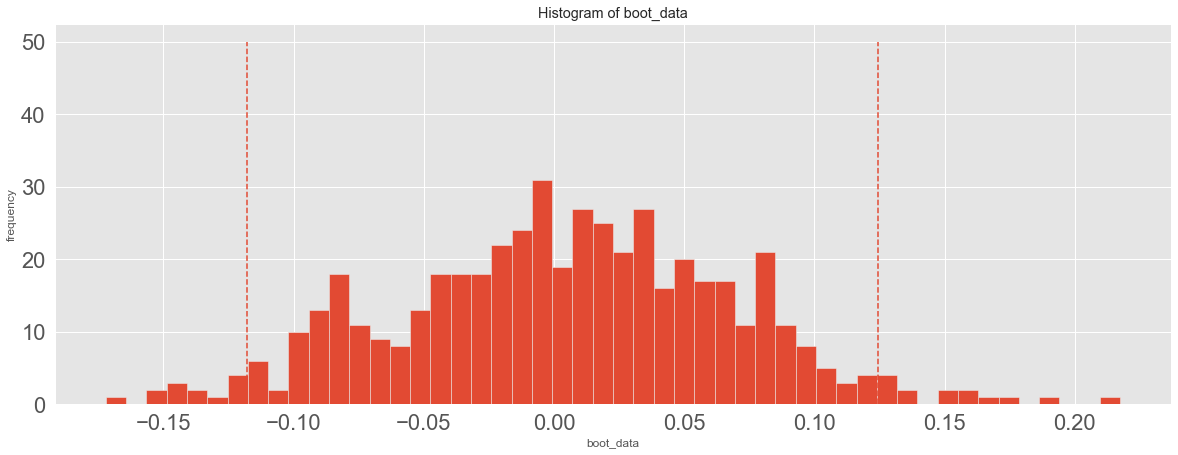

In [26]:
booted_data = get_bootstrap(control_without_major_outlier.value, test_without_major_outlier.value, statistic = np.mean, boot_it = 500)

Посмотрим уровень значимости...

In [27]:
booted_data["p_value"]

0.9453994187833807

И получаем результат даже выше, чем при применении критерия Манна-Уитни

Исходя из результата теста, мы не можем отвергнуть нулевую гипотезу. 

## Итого
* Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
* Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
* Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
* U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы


В данном эксперементе мы не нашли стастистически значимых отличий